In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Permeabilities
P = {'CO2':4000,
     'O2':600,
     'N2':200} #Barrer

# Inlet mole fractions & flowrate
X = {'CO2':0.04,
     'O2':0.56,
     'N2':0.4}

Lf = 1/60*1000 #cm3/s (1 L/min)

# Fibre properties
d_i = 0.365/10 # cm (0.365 mm)

In [3]:
# Design requirements

# Nonpermeate (effluent) CO2 requirement
x_target = 0.00499

# Max feed side pressure
p_h_max = 0.1 # atm(gauge)

In [4]:
# Selectivities
alpha_CO2_O2 = P['CO2']/P['O2']
alpha_CO2_N2 = P['CO2']/P['N2']

In [5]:
# Function
# Specify p_h, p_l in bar and delta in m
def calculate(X,Lf,p_h,p_l,phi,delta):
    global P
    Lp = phi*Lf
    p_h, p_l = p_h*75.006, p_l*75.006 # convert bar to cmHg
    # convert Barrer to (cm3(STP).cm/(cm2.s.cmHg))
    P_CO2, P_O2, P_N2 = P['CO2']*1e-10, P['O2']*1e-10, P['N2']*1e-10
    y_range = np.arange(0.00001,0.5,0.00001)
    y_total = 0
    for y_CO2 in y_range:
        y_total = 0
        A = Lp*y_CO2*delta/P_CO2/(p_h/(1-phi)*(X['CO2']-phi*y_CO2)-p_l*y_CO2)
        y_O2 = p_h*X['O2']/(1-phi)/(Lp*delta/(P_O2*A)+phi/(1-phi)*p_h+p_l)
        y_N2 = p_h*X['N2']/(1-phi)/(Lp*delta/(P_N2*A)+phi/(1-phi)*p_h+p_l)
        y_total = y_CO2 + y_O2 + y_N2
        #print('CO2:{:.5f}, O2:{:.5f}, N2:{:.5f}'.format(y_CO2,y_O2,y_N2))
        #print('Sum:{:.5f}'.format(y_total))
        if (abs(y_total - 1) <= 1e-3) and (y_O2>0) and (y_N2>0):
            break
            #print('CO2:{:.5f}, O2:{:.5f}, N2:{:.5f}'.format(y_CO2,y_O2,y_N2))
    return y_CO2,y_O2,y_N2,A,Lp

In [ ]:
# Test cell
p_h = (p_h_max + 1)*1.01325 #bar
p_l = 0.0001 # bar
phi = 0.732
delta = 200*1e-4 # μm to cm
y = {}
y['CO2'],y['O2'],y['N2'],A,Lp = calculate(X,Lf,p_h,p_l,phi,delta)
x = {}
for key in y.keys():
    x[key] = (X[key]-phi*y[key])/(1-phi)
print(x)

{'CO2': 0.004956865671641765, 'O2': 0.3891066078979763, 'N2': 0.607500700553284}


In [ ]:
# Initial results for report - 1 stage
phi_range = np.arange(0.3,0.9,0.001)
p_h = (p_h_max + 1)*1.01325 #bar
p_l =  1/750 # mmHg to bar
delta = 100*1e-4 # μm to cm
y,x = {},{}
columns=['y_CO2','y_O2','y_N2','x_CO2','x_O2','x_N2','A','phi','O2_rec','Lp','Lu','p_l']
results = pd.DataFrame(columns=columns)
x_range = 0.004

for i,phi in enumerate(phi_range):
    y['CO2'],y['O2'],y['N2'],A_t,Lp = calculate(X,Lf,p_h,p_l,phi,delta)
    for key in y.keys():
        x[key] = (X[key]-phi*y[key])/(1-phi)
    Lu = Lf-Lp
    O2_rec = Lu*x['O2']/(Lf*X['O2'])
    results_dict = {i:{'y_CO2':y['CO2'],
                    'y_O2':y['O2'],
                    'y_N2':y['N2'],
                    'x_CO2':x['CO2'],
                    'x_O2':x['O2'],
                    'x_N2':x['N2'],
                    'A':A_t,
                    'phi':phi,
                    'O2_rec':O2_rec,
                    'Lp':Lp,
                    'Lu':Lu,
                    'p_l':p_l}}
    df_dict = pd.DataFrame.from_dict(results_dict,orient='index')
    results = pd.concat([results,df_dict])
    if abs(x['CO2']-x_range)<=1e-5:
        break

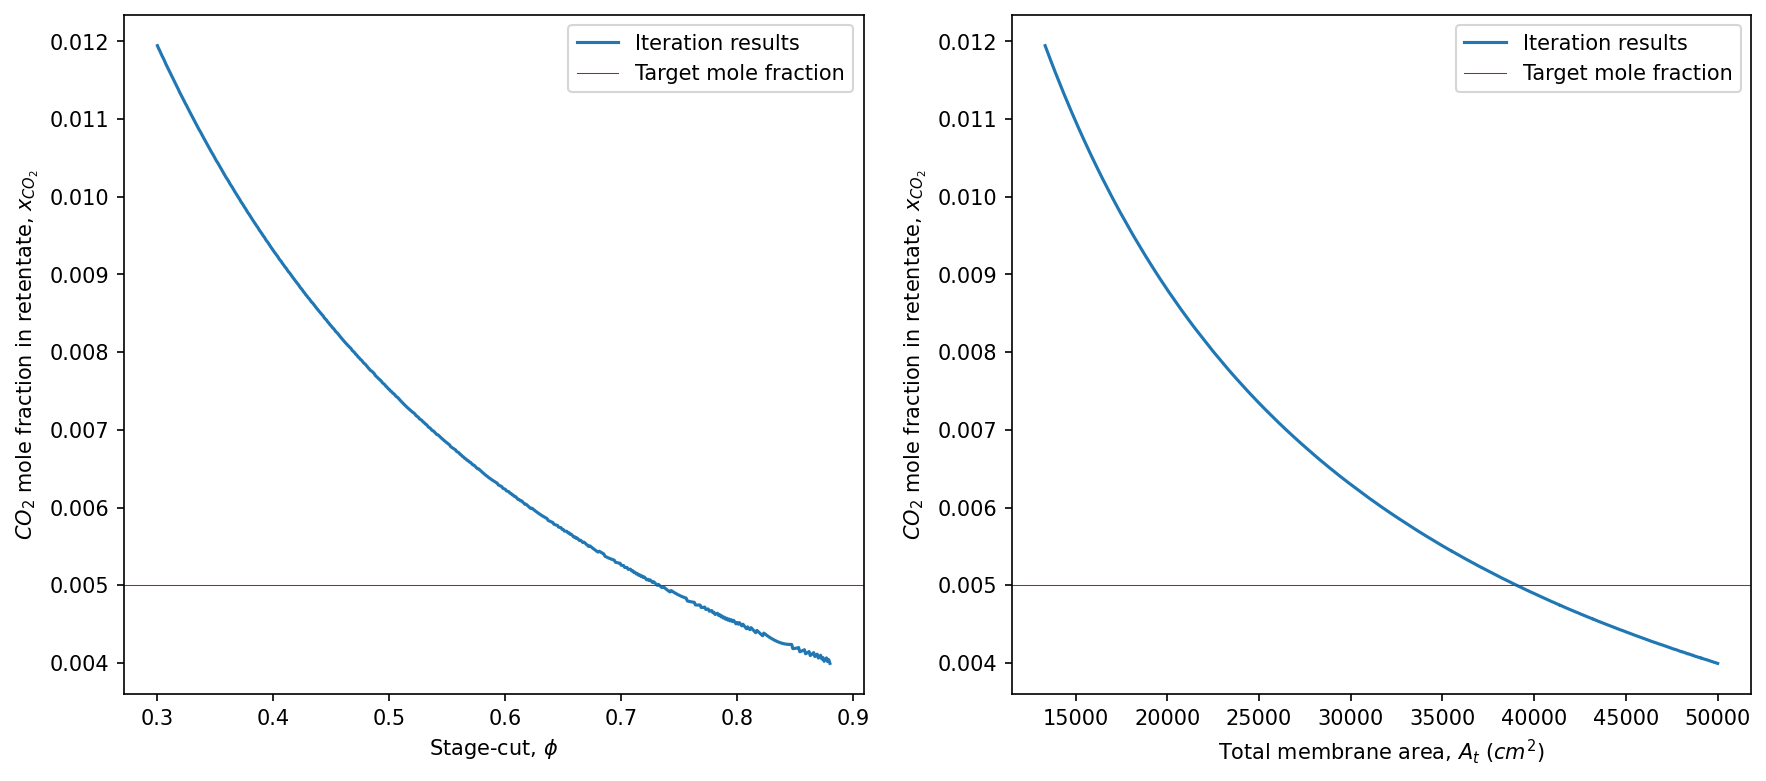

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(14,6),dpi=150)

graph1 = sns.lineplot(x='phi',y='x_CO2',data=results,ax=axes[0])
axes[0].set(xlabel='Stage-cut, $\phi$', ylabel='$CO_2$ mole fraction in retentate, $x_{CO_2}$')
graph1.axhline(0.005,color='r',lw=0.5)
axes[0].legend(['Iteration results','Target mole fraction'])

graph2 = sns.lineplot(x='A',y='x_CO2',data=results,ax=axes[1])
axes[1].set(xlabel='Total membrane area, $A_t$ ($cm^2$)', ylabel='$CO_2$ mole fraction in retentate, $x_{CO_2}$')
graph2.axhline(0.005,color='r',lw=0.5)
axes[1].legend(['Iteration results','Target mole fraction'])
plt.savefig('initial-results.png')
plt.show()

In [ ]:
results[results['x_CO2']==results[(x_target-results['x_CO2'])>=0.5e-4]['x_CO2'].max()]

,y_CO2,y_O2,y_N2,x_CO2,x_O2,x_N2,A,phi,O2_rec,Lp,Lu,p_l
440,0.05232,0.621019,0.326635,0.004935,0.386331,0.608809,39600.867865,0.74,0.179368,12.333333,4.333333,0.001333


In [ ]:
optimum_stage1 = results[results['x_CO2']==results[(x_target-results['x_CO2'])>=0.5e-4]['x_CO2'].max()].to_dict('records')
optimum_stage1 = optimum_stage1[0]
optimum_stage1

{'A': 39600.8678650267,
 'Lp': 12.333333333333341,
 'Lu': 4.333333333333327,
 'O2_rec': 0.17936808993261183,
 'p_l': 0.0013333333333333333,
 'phi': 0.7400000000000004,
 'x_CO2': 0.004935384615384537,
 'x_N2': 0.6088094379241382,
 'x_O2': 0.3863312706240877,
 'y_CO2': 0.052320000000000005,
 'y_N2': 0.3266345218104381,
 'y_O2': 0.6210187427536988}

In [ ]:
# Stage 2 with permeate as feed
Lf2 = optimum_stage1['Lp'] #cm3/s
X2 = {'CO2':optimum_stage1['y_CO2'],
      'N2':optimum_stage1['y_N2'],
      'O2':optimum_stage1['y_O2']}
p_h2 = p_h #bar
p_l2 = p_l #bar
delta2 = delta #cm

In [ ]:
phi_range2 = np.arange(0.1,0.99,0.001)
y2,x2 = {},{}
columns=['y_CO2','y_O2','y_N2','x_CO2','x_O2','x_N2','A','phi','O2_rec']
results2 = pd.DataFrame(columns=columns)
x_range = 0.004

for i,phi2 in enumerate(phi_range2):
    y2['CO2'],y2['O2'],y2['N2'],A_t2,Lp2 = calculate(X2,Lf2,p_h2,p_l2,phi2,delta2)
    for key in y2.keys():
        x2[key] = (X2[key]-phi2*y2[key])/(1-phi2)
    Lu2 = Lf2-Lp2
    O2_rec2 = Lu2*x2['O2']/(Lf*X2['O2'])
    results_dict2 = {i:{'y_CO2':y2['CO2'],
                    'y_O2':y2['O2'],
                    'y_N2':y2['N2'],
                    'x_CO2':x2['CO2'],
                    'x_O2':x2['O2'],
                    'x_N2':x2['N2'],
                    'A':A_t2,
                    'phi':phi2,
                    'Lp':Lp2,
                    'O2_rec':O2_rec2}}
    df_dict2 = pd.DataFrame.from_dict(results_dict2,orient='index')
    results2 = pd.concat([results2,df_dict2])
    if abs(x2['CO2']-x_range)<=1e-5:
        break

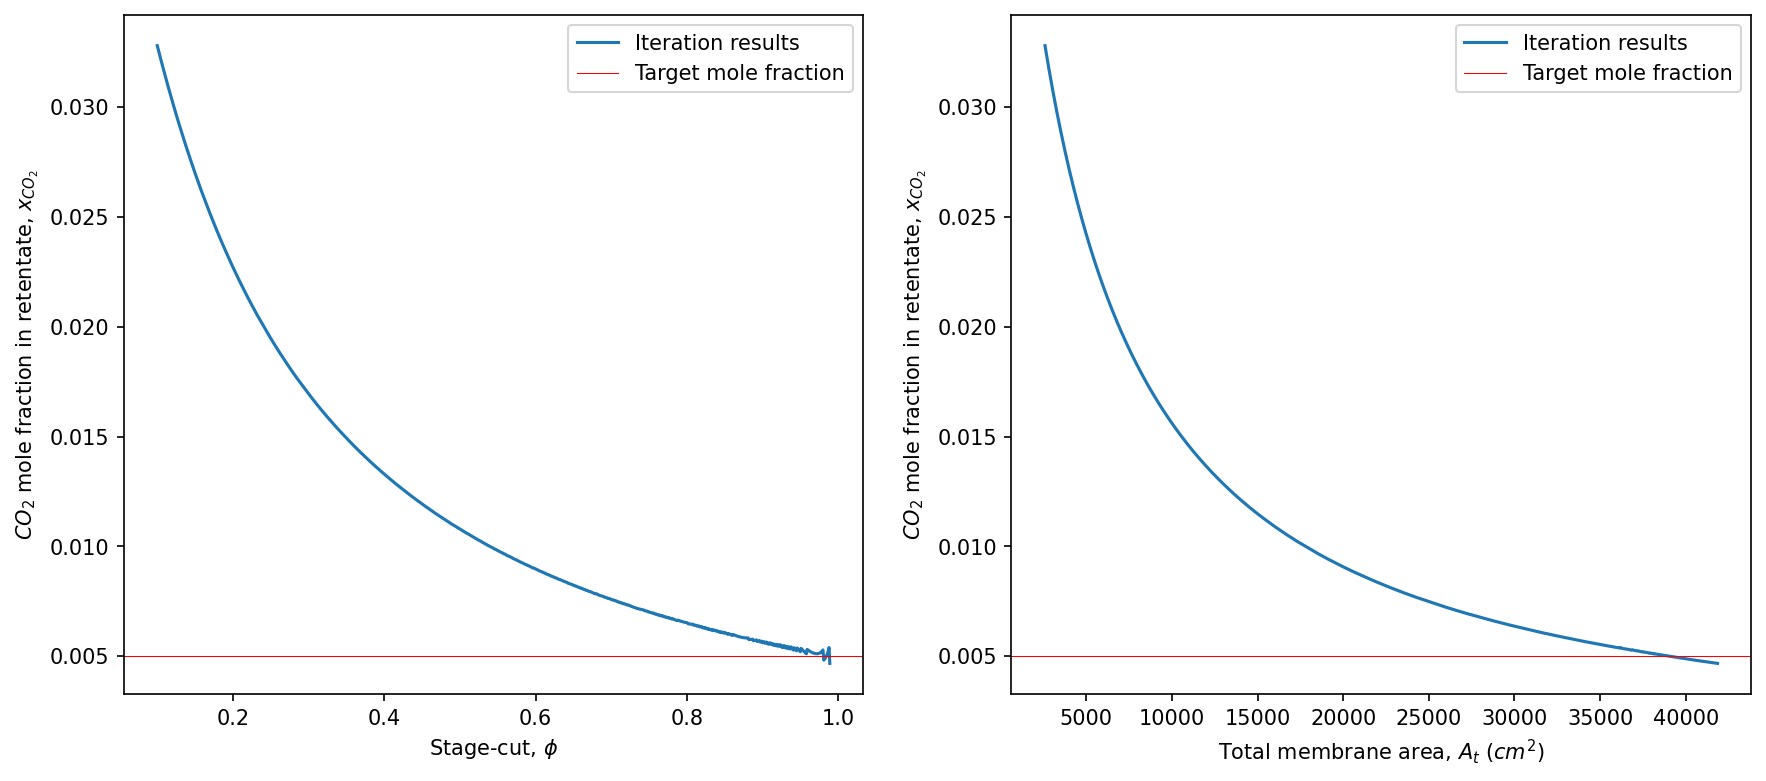

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(14,6),dpi=150)

graph1 = sns.lineplot(x='phi',y='x_CO2',data=results2,ax=axes[0])
axes[0].set(xlabel='Stage-cut, $\phi$', ylabel='$CO_2$ mole fraction in retentate, $x_{CO_2}$')
graph1.axhline(0.005,color='r',lw=0.5)
axes[0].legend(['Iteration results','Target mole fraction'])

graph2 = sns.lineplot(x='A',y='x_CO2',data=results2,ax=axes[1])
axes[1].set(xlabel='Total membrane area, $A_t$ ($cm^2$)', ylabel='$CO_2$ mole fraction in retentate, $x_{CO_2}$')
graph2.axhline(0.005,color='r',lw=0.5)
axes[1].legend(['Iteration results','Target mole fraction'])
plt.savefig('initial-results-stage2.png')
plt.show()

In [ ]:
optimum_stage2 = results2[results2['x_CO2']==results2[(x_target-results2['x_CO2'])>=0.5e-4]['x_CO2'].max()].to_dict('records')
optimum_stage2 = optimum_stage2[0]
optimum_stage2

{'A': 39796.32363667565,
 'Lp': 12.123666666666683,
 'O2_rec': 0.007706718768065512,
 'phi': 0.9830000000000008,
 'x_CO2': 0.0049047058823507685,
 'x_N2': 0.5873096133270461,
 'x_O2': 0.38044648649448104,
 'y_CO2': 0.05314000000000001,
 'y_N2': 0.32212640730811654,
 'y_O2': 0.6251791988639801}

In [ ]:
# Sensitivity analysis on thickness
phi_range = np.arange(0.3,0.9,0.001)
p_h = (p_h_max + 1)*1.01325 #bar
p_l =  1/750 # mmHg to bar
og_delta = 100*1e-4 # μm to cm
delta_range = [-0.5,-0.25,0,0.25,0.5]
y,x = {},{}
columns=['delta','y_CO2','y_O2','y_N2','x_CO2','x_O2','x_N2','A','phi','O2_rec','Lp','Lu','p_l']
results = pd.DataFrame(columns=columns)
x_range = 0.004

for i,var in enumerate(delta_range):
    delta = og_delta + og_delta*var
    for j,phi in enumerate(phi_range):
        y['CO2'],y['O2'],y['N2'],A_t,Lp = calculate(X,Lf,p_h,p_l,phi,delta)
        for key in y.keys():
            x[key] = (X[key]-phi*y[key])/(1-phi)
        Lu = Lf-Lp
        O2_rec = Lu*x['O2']/(Lf*X['O2'])
        results_dict = {j:{'delta':delta,
                        'y_CO2':y['CO2'],
                        'y_O2':y['O2'],
                        'y_N2':y['N2'],
                        'x_CO2':x['CO2'],
                        'x_O2':x['O2'],
                        'x_N2':x['N2'],
                        'A':A_t,
                        'phi':phi,
                        'O2_rec':O2_rec,
                        'Lp':Lp,
                        'Lu':Lu,
                        'p_l':p_l}}
        df_dict = pd.DataFrame.from_dict(results_dict,orient='index')
        results = pd.concat([results,df_dict])
        if abs(x['CO2']-x_range)<=1e-5:
            break

In [ ]:
optimum_stages = results[results['x_CO2']==results[(x_target-results['x_CO2'])>=0.5e-4]['x_CO2'].max()]
optimum_stages['delta'] = optimum_stages['delta']*1e4
optimum_stages.reset_index(inplace=True,drop=True)
optimum_stages

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,delta,y_CO2,y_O2,y_N2,x_CO2,x_O2,x_N2,A,phi,O2_rec,Lp,Lu,p_l
0,50.0,0.05232,0.621019,0.326635,0.004935,0.386331,0.608809,19800.433933,0.74,0.179368,12.333333,4.333333,0.001333
1,75.0,0.05232,0.621019,0.326635,0.004935,0.386331,0.608809,29700.650899,0.74,0.179368,12.333333,4.333333,0.001333
2,100.0,0.05232,0.621019,0.326635,0.004935,0.386331,0.608809,39600.867865,0.74,0.179368,12.333333,4.333333,0.001333
3,125.0,0.05232,0.621019,0.326635,0.004935,0.386331,0.608809,49501.084831,0.74,0.179368,12.333333,4.333333,0.001333
4,150.0,0.05232,0.621019,0.326635,0.004935,0.386331,0.608809,59401.301798,0.74,0.179368,12.333333,4.333333,0.001333


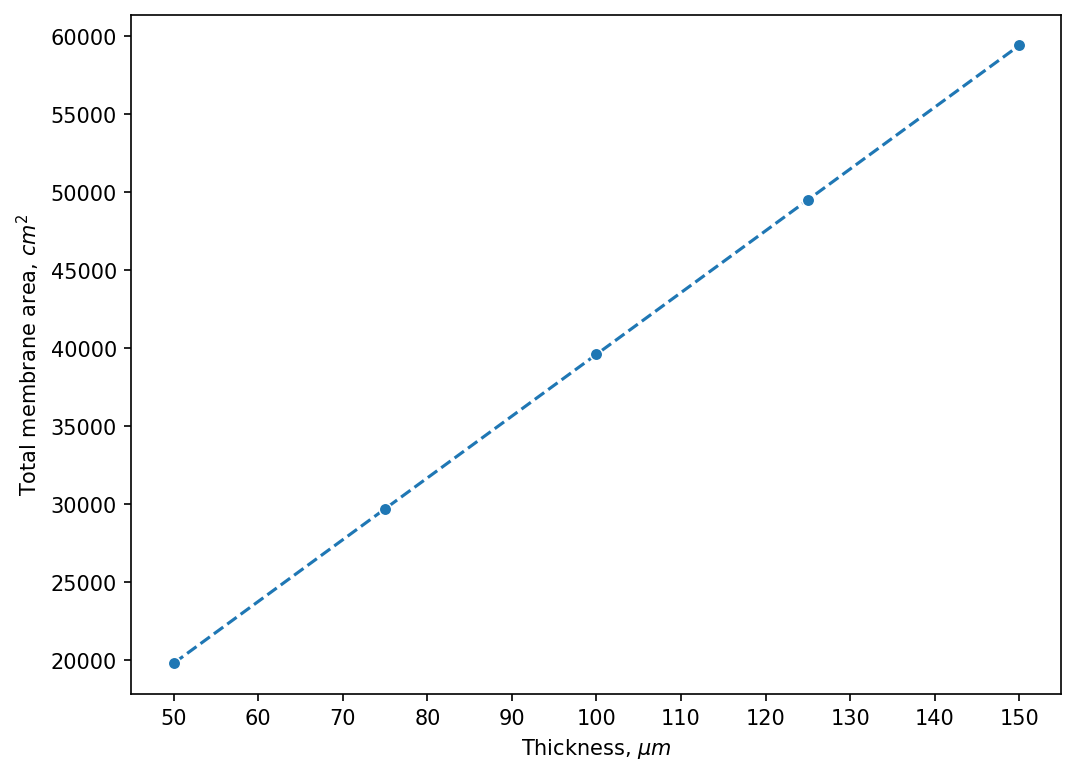

In [ ]:
plt.figure(figsize=(8,6),dpi=150)
graph = sns.lineplot(x='delta',y='A',data=optimum_stages,marker='o',linestyle='--')
graph.set(xlabel='Thickness, $\mu m$', ylabel='Total membrane area, $cm^2$')
plt.xlim(45,155)
plt.xticks(np.arange(50, 160, 10))
# ax.set_xticks(np.arange)
plt.savefig('sensitivity-results.png')
plt.show()

In [6]:
# Optimised beta results (p_l = 3 Torr)
phi_range = np.arange(0.3,0.9,0.001)
p_h = (p_h_max + 1)*1.01325 #bar
p_l = 3/750 # bar
delta = 100*1e-4 # μm to cm
y,x = {},{}
columns=['y_CO2','y_O2','y_N2','x_CO2','x_O2','x_N2','A','phi','O2_rec','Lp','Lu','p_l']
results = pd.DataFrame(columns=columns)
x_range = 0.004

for i,phi in enumerate(phi_range):
    y['CO2'],y['O2'],y['N2'],A_t,Lp = calculate(X,Lf,p_h,p_l,phi,delta)
    for key in y.keys():
        x[key] = (X[key]-phi*y[key])/(1-phi)
    Lu = Lf-Lp
    O2_rec = Lu*x['O2']/(Lf*X['O2'])
    results_dict = {i:{'y_CO2':y['CO2'],
                    'y_O2':y['O2'],
                    'y_N2':y['N2'],
                    'x_CO2':x['CO2'],
                    'x_O2':x['O2'],
                    'x_N2':x['N2'],
                    'A':A_t,
                    'phi':phi,
                    'O2_rec':O2_rec,
                    'Lp':Lp,
                    'Lu':Lu,
                    'p_l':p_l}}
    df_dict = pd.DataFrame.from_dict(results_dict,orient='index')
    results = pd.concat([results,df_dict])
    if abs(x['CO2']-x_range)<=1e-5:
        break

In [7]:
results.sort_values('A',axis=0,inplace=True)
results

,y_CO2,y_O2,y_N2,x_CO2,x_O2,x_N2,A,phi,O2_rec,Lp,Lu,p_l
596,0.49999,-0.123182,-0.025922,-3.922991,6.445879,4.069480,-568.901261,0.896,1.197092,14.933333,1.733333,0.004
0,0.10507,0.679814,0.214335,0.012113,0.508651,0.479571,13386.636090,0.300,0.635814,5.000000,11.666667,0.004
1,0.10483,0.679678,0.214507,0.012083,0.508465,0.479876,13433.518559,0.301,0.634673,5.016667,11.650000,0.004
2,0.10460,0.679722,0.214755,0.012050,0.508201,0.480149,13486.057913,0.302,0.633436,5.033333,11.633333,0.004
3,0.10437,0.679745,0.214995,0.012017,0.507944,0.480426,13538.037871,0.303,0.632209,5.050000,11.616667,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...
591,0.04440,0.586517,0.369827,0.004033,0.343243,0.646640,50900.249206,0.891,0.066810,14.850000,1.816667,0.004
597,0.04413,0.584760,0.370977,0.004033,0.344371,0.652754,50920.171937,0.897,0.063340,14.950000,1.716667,0.004
593,0.04431,0.585961,0.370261,0.004030,0.343339,0.648196,50951.586135,0.893,0.065602,14.883333,1.783333,0.004
595,0.04422,0.585375,0.370644,0.004030,0.343709,0.650222,50959.072833,0.895,0.064445,14.916667,1.750000,0.004


In [8]:
results[results['x_CO2']==results[(x_target-results['x_CO2'])>=0.5e-4]['x_CO2'].max()]

,y_CO2,y_O2,y_N2,x_CO2,x_O2,x_N2,A,phi,O2_rec,Lp,Lu,p_l
454,0.05144,0.617854,0.330763,0.004936,0.382677,0.612214,40685.615265,0.754,0.168104,12.566667,4.1,0.004


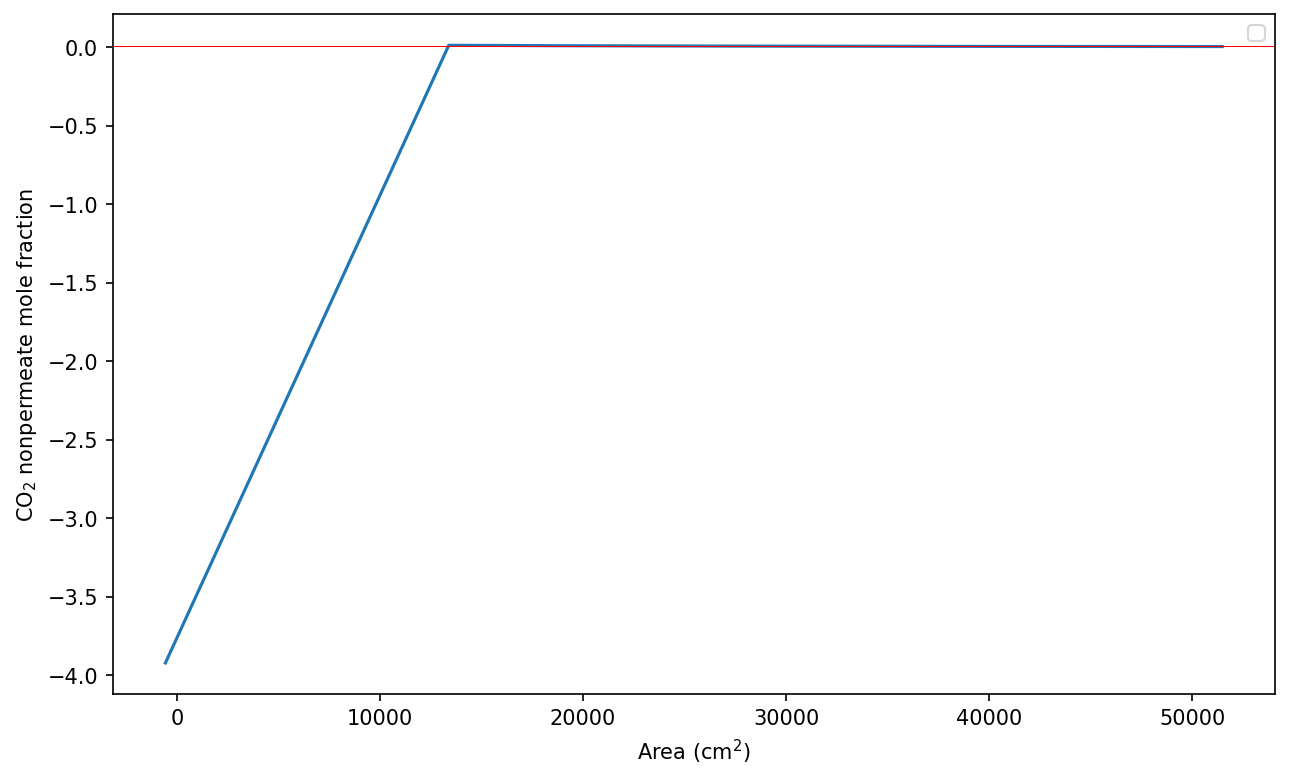

In [ ]:
plt.figure(figsize=(10,6),dpi=150)
graph = sns.lineplot(x='A',y='x_CO2',data=results)
graph.axhline(0.005,color='r',lw=0.5)
plt.xlabel('Area (cm$^2$)')
plt.ylabel('CO$_2$ nonpermeate mole fraction')
plt.legend([])
plt.savefig('CO2_effluent_vs_area.png')
plt.show()

In [9]:
phi_range = np.arange(0.1,0.9,0.001)
p_l_range = np.arange(1,11,1) #mmHg
p_h = (p_h_max + 1)*1.01325 #bar
delta = 100*1e-4 # μm to cm
y,x = {},{}
columns=['y_CO2','y_O2','y_N2','x_CO2','x_O2','x_N2','A','phi','O2_rec','Lp','Lu','p_l']
x_range = 0.004
opt_results = pd.DataFrame(columns=columns)
for i,p_l in enumerate(p_l_range):
    p_l = p_l/750
    results = pd.DataFrame(columns=columns)
    results_dict = dict()
    df_dict = pd.DataFrame(columns=columns)
    for j,phi in enumerate(phi_range):
        y['CO2'],y['O2'],y['N2'],A_t,Lp = calculate(X,Lf,p_h,p_l,phi,delta)
        for key in y.keys():
            x[key] = (X[key]-phi*y[key])/(1-phi)
        Lu = Lf-Lp
        O2_rec = Lu*x['O2']/(Lf*X['O2'])
        results_dict = {j:{'y_CO2':y['CO2'],
                        'y_O2':y['O2'],
                        'y_N2':y['N2'],
                        'x_CO2':x['CO2'],
                        'x_O2':x['O2'],
                        'x_N2':x['N2'],
                        'A':A_t,
                        'phi':phi,
                        'O2_rec':O2_rec,
                        'Lp':Lp,
                        'Lu':Lu,
                        'p_l':p_l}}
        df_dict = pd.DataFrame.from_dict(results_dict,orient='index')
        results = pd.concat([results,df_dict])
        if abs(x['CO2']-x_range)<=1e-5:
            break
    opt_stage = results[results['x_CO2']==results[(x_target-results['x_CO2'])>=0.5e-5]['x_CO2'].max()]
    opt_stage.reset_index(inplace=True,drop=True)
    opt_results = pd.concat([opt_results,opt_stage])
    print(opt_stage)

     y_CO2      y_O2      y_N2     x_CO2     x_O2     x_N2             A  \
0  0.05256  0.621455  0.325018  0.004984  0.38867  0.60904  39176.977093   

     phi   O2_rec         Lp   Lu       p_l  
0  0.736  0.18323  12.266667  4.4  0.001333  
     y_CO2      y_O2      y_N2     x_CO2      x_O2      x_N2             A  \
0  0.05224  0.620751  0.327021  0.004981  0.386193  0.608792  39728.023956   

     phi    O2_rec     Lp        Lu       p_l  
0  0.741  0.178614  12.35  4.316667  0.002667  
     y_CO2      y_O2      y_N2     x_CO2      x_O2      x_N2             A  \
0  0.05186  0.619535  0.328976  0.004983  0.384219  0.609705  40255.008262   

     phi    O2_rec     Lp        Lu    p_l  
0  0.747  0.173585  12.45  4.216667  0.004  
     y_CO2      y_O2      y_N2     x_CO2      x_O2      x_N2            A  \
0  0.05124  0.616732  0.331205  0.004985  0.383267  0.614311  40788.76002   

     phi   O2_rec         Lp    Lu       p_l  
0  0.757  0.16631  12.616667  4.05  0.005333  
     y

In [10]:
opt_results

,y_CO2,y_O2,y_N2,x_CO2,x_O2,x_N2,A,phi,O2_rec,Lp,Lu,p_l
0,0.05256,0.621455,0.325018,0.004984,0.388670,0.609040,39176.977093,0.736,0.183230,12.266667,4.400000,0.001333
0,0.05224,0.620751,0.327021,0.004981,0.386193,0.608792,39728.023956,0.741,0.178614,12.350000,4.316667,0.002667
0,0.05186,0.619535,0.328976,0.004983,0.384219,0.609705,40255.008262,0.747,0.173585,12.450000,4.216667,0.004000
0,0.05124,0.616732,0.331205,0.004985,0.383267,0.614311,40788.760020,0.757,0.166310,12.616667,4.050000,0.005333
0,0.05094,0.616163,0.333416,0.004974,0.380183,0.613181,41436.267307,0.762,0.161578,12.700000,3.966667,0.006667
0,0.05046,0.614018,0.335352,0.004982,0.379158,0.616429,41919.989790,0.770,0.155726,12.833333,3.833333,0.008000
0,0.05005,0.612408,0.337400,0.004983,0.377396,0.618117,42471.626150,0.777,0.150284,12.950000,3.716667,0.009333
0,0.04965,0.610987,0.339699,0.004974,0.374935,0.618871,43123.196555,0.784,0.144618,13.066667,3.600000,0.010667
0,0.04931,0.609700,0.341608,0.004977,0.373033,0.619664,43671.508558,0.790,0.139888,13.166667,3.500000,0.012000
0,0.04870,0.606578,0.343975,0.004981,0.372517,0.625506,44198.590675,0.801,0.132377,13.350000,3.316667,0.013333


In [11]:
delta = 100*1e-4 # μm to cm
A_total = 40685.62 #cm2
d_o = d_i + delta*2 #cm
d_o

0.056499999999999995

In [12]:
L_range = np.arange(20,200,1) #cm
columns = ['L','A_fibre','n_fibres']
fibre_results = pd.DataFrame(columns=columns)
for i,L in enumerate(L_range):
    A_fibre = np.pi*d_o*L
    n_fibres = A_total/A_fibre
    fib_results_dict = {i:{'L':L,
                       'A_fibre':A_fibre,
                       'n_fibres':n_fibres}}
    fib_df_dict = pd.DataFrame.from_dict(fib_results_dict,orient='index',columns=columns)
    fibre_results = pd.concat([fibre_results,fib_df_dict])

In [13]:
fibre_results[fibre_results['L']==50]

,L,A_fibre,n_fibres
30,50,8.874999,4584.295601


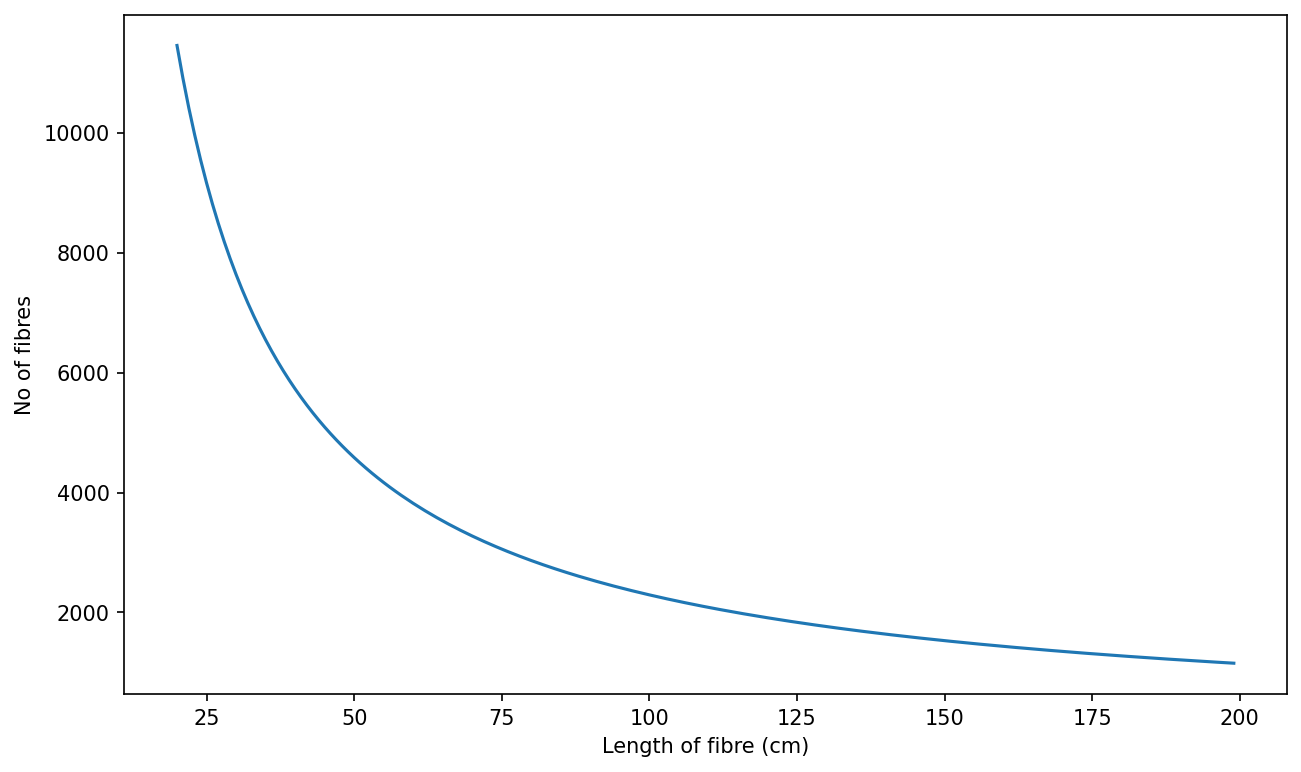

In [14]:
plt.figure(figsize=(10,6),dpi=150)
graph = sns.lineplot(x='L',y='n_fibres',data=fibre_results)
plt.xlabel('Length of fibre (cm)')
plt.ylabel('No of fibres')
plt.savefig('no_fibres_stage1.png')
plt.show()

In [ ]:
results2

,y_CO2,y_O2,y_N2,x_CO2,x_O2,x_N2,A,phi,O2_rec,Lp
0,0.23172,0.647463,0.119841,0.033376,0.621382,0.345020,2513.770950,0.100,0.650669,1.2100
1,0.23099,0.648020,0.120041,0.033237,0.621291,0.345248,2541.466943,0.101,0.649850,1.2221
2,0.23026,0.648557,0.120238,0.033100,0.621200,0.345477,2569.132939,0.102,0.649033,1.2342
3,0.22953,0.649074,0.120431,0.032964,0.621110,0.345706,2596.764897,0.103,0.648216,1.2463
4,0.22881,0.649617,0.120630,0.032828,0.621016,0.345934,2624.566326,0.104,0.647395,1.2584
...,...,...,...,...,...,...,...,...,...,...
885,0.05394,0.627272,0.317955,0.005273,0.408507,0.621142,36490.580601,0.985,0.007129,11.9185
886,0.05389,0.626997,0.318172,0.005319,0.412217,0.627485,36183.049624,0.986,0.006714,11.9306
887,0.05385,0.627487,0.319537,0.004619,0.358518,0.547650,41678.085418,0.987,0.005423,11.9427
888,0.05380,0.627199,0.319737,0.004633,0.359783,0.550179,41554.535231,0.988,0.005023,11.9548


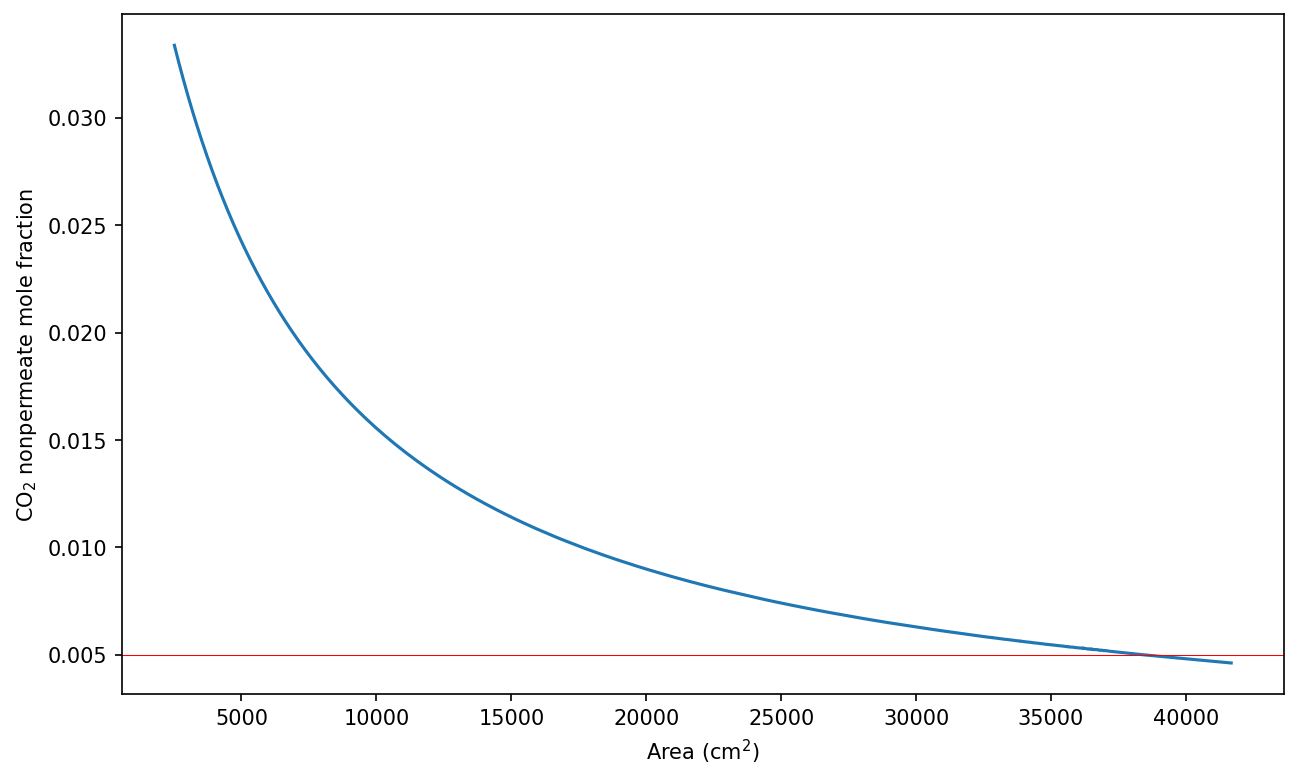

In [ ]:
plt.figure(figsize=(10,6),dpi=150)
graph = sns.lineplot(x='A',y='x_CO2',data=results2)
graph.axhline(0.005,color='r',lw=0.5)
plt.xlabel('Area (cm$^2$)')
plt.ylabel('CO$_2$ nonpermeate mole fraction')
plt.savefig('CO2_effluent_vs_area2.png')
plt.show()

In [ ]:
optimum_stage2 = dict(results2[abs(results2['x_CO2']-x_target)<=1e-5].iloc[0])
optimum_stage2

{'A': 38480.03944995077,
 'Lp': 11.74910000000002,
 'O2_rec': 0.0129648135432163,
 'phi': 0.9710000000000008,
 'x_CO2': 0.004994827586205656,
 'x_N2': 0.5751813994923347,
 'x_O2': 0.38424606121896704,
 'y_CO2': 0.054650000000000004,
 'y_N2': 0.3149558674946178,
 'y_O2': 0.631150424777627}